<a href="https://colab.research.google.com/github/Arvinth-s/Dark-Sight/blob/master/DarkSight_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#OM NAMO NARAYANA

In [2]:
from google.colab import drive
import numpy as np
import os
drive.flush_and_unmount()
drive.mount('/content/drive')
dsdir='/content/drive/My Drive/Dataset/'
f = open(dsdir+'logs.txt', 'w')
f.write('successfully mounted drive\n')

Mounted at /content/drive


27

In [3]:
dataset_dir = '/content/drive/My Drive/Dataset/Dataset/'
os.chdir(dsdir)
!ls
os.chdir(dataset_dir)
f.write('Dataset exists\n')

Dataset       logs.txt	      myFile_raw_jpg.txt
files_gen.py  myFile_jpg.txt  myFile_raw.txt


15

In [4]:
subdirs=[]
f.write('Dataset extracted\n')
for path, sd, files in os.walk(dataset_dir):
    if(sd != []):
      subdirs.append(sd)
subdirs=subdirs[0]
A=[]
for subdir in subdirs:
  a = list(os.listdir(subdir))
  a.sort()
  if(len(a)==10):
    a.append(subdir)
    A.append(a)
A = np.array(A)
longExposure=[]
shortExposure=[]
temperature=[]
longExposure = [dataset_dir + a[10] + "/" + a[4] for a in A]
shortExposure =[dataset_dir + a[10] + "/" +a[5] for a in A]
temperature = [dataset_dir + a[10] + "/" +a[6] for a in A]
f.write('Dataset extracted\n')

18

In [5]:
# imports
import torch
import torchvision.transforms as transforms
import glob
import matplotlib.pyplot as plt
import torchvision
import time
import albumentations as A
 
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [6]:
def show_img(img):
    plt.figure(figsize=(18,15))
    # unnormalize
    img = img / 2 + 0.5  
    npimg = img.numpy()
    npimg = np.clip(npimg, 0., 1.)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    return np.transpose(npimg, (1, 2, 0))

[call](https://www.geeksforgeeks.org/__call__-in-python/)

[special function
](https://discuss.pytorch.org/t/using-a-special-function-as-a-transform/42760)

In [7]:
#parameters
batch_size=16
cropping_ratio=0.75
width=100

In [8]:
class myTransforms():
  class Resize():
    def __init__(self, size, interpolation=Image.BILINEAR):
      self.size=size
      self.interpolation=interpolation
    def __call__(self, img):
      old_size = img.size
      ratio = float(self.size)/max(old_size)
      new_size = tuple([int(x * ratio) for x in old_size])

      return (img.resize(new_size, resample=self.interpolation))
  class CenterCrop():
    def __init__(self, ratio, interpolation=Image.BILINEAR):
      self.ratio=ratio
      self.interpolation=interpolation
    def __call__(self, img):
      old_size=img.size
      left = (1-self.ratio)*(old_size[0]/2)
      right = (1+self.ratio)*(old_size[0]/2)
      top = (1-self.ratio)*(old_size[1]/2)
      bottom = (1+self.ratio)*(old_size[1]/2)
      #LTRB
      img=img.crop((left, top, right, bottom))
      return img
  class CorrectSize():
    def __init__(self, size, interpolation=Image.BILINEAR):
      self.size=size
      self.ratio=1
      self.interpolation=interpolation
    def __call__(self, img):
      self.ratio = int(max(self.size[0]/img.size[0], self.size[1]/img.size[1]))
      img = img.resize((img.size[0]*self.ratio, img.size[1]*self.ratio))
      width=img.size[0]
      height=img.size[1]
      left=(width-self.size[0])/2
      right=(width + self.size[0])/2
      top=(height-self.size[1])/2
      bottom=(height+self.size[1])/2
      img = img.crop((left, top, right, bottom))
      return img

In [24]:
# define pytorch transforms
Transforms=[]
Transforms.append(
    transforms.Compose([
     transforms.ToPILImage(),
     transforms.RandomRotation(degrees=(-20, 20)),
     transforms.Resize((300, 300)),
     transforms.CenterCrop((280, 280)),
     transforms.RandomCrop((80, 80)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor(),
     #mean and std=0.5
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])
)

In [25]:
print(len(longExposure))
limg=plt.imread(longExposure[0])
sh=(np.array(limg)).shape
print(sh)

145
(1984, 2976, 3)


In [26]:
# define pytorch transforms
Transforms.append(
    transforms.Compose([
     transforms.ToPILImage(),
     transforms.RandomRotation(degrees=(-15, 15)),
     myTransforms.CorrectSize((sh[0], sh[1])),
     myTransforms.Resize(300),
     myTransforms.CenterCrop(0.75),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor(),
     #mean and std=0.5
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])
)

In [27]:
# PyTorch image augmentation module
image_list = [longExposure, shortExposure, temperature]
class PyTorchImageDataset(Dataset):
    def __init__(self, image_list, transforms=None):
        self.image_list = image_list
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.image_list))

    
    def __getitem__(self, i):
        image = []
        image = [plt.imread(self.image_list[j][i]) for j in range(3)]
        print(image[0].shape, image[1].shape, image[2].shape)
        image = [Image.fromarray(img).convert('RGB')  for img in image]
        image = [np.asarray(img).astype(np.uint8) for img in image]
        if self.transforms is not None:
            image = [self.transforms(np.asarray(img)) for img in image]
        image = np.array([img.numpy() for img in image])
        print('shape of array inside class: ', np.array(image).shape)
        return torch.tensor(image, dtype=torch.float)

In [28]:
pytorch_dataset = PyTorchImageDataset(image_list=image_list, transforms=Transforms[1])
#batch_size <= 3
pytorch_dataloader1 = DataLoader(dataset=pytorch_dataset, batch_size=15, shuffle=True)


(1984, 2976, 3) (1984, 2976, 3) (24, 32, 3)
shape of array inside class:  (3, 3, 224, 150)
(1984, 2976, 3) (1984, 2976, 3) (24, 32, 3)
shape of array inside class:  (3, 3, 224, 150)
(1984, 2976, 3) (1984, 2976, 3) (24, 32, 3)
shape of array inside class:  (3, 3, 224, 150)
final shape of data (3, 3, 3, 224, 150)


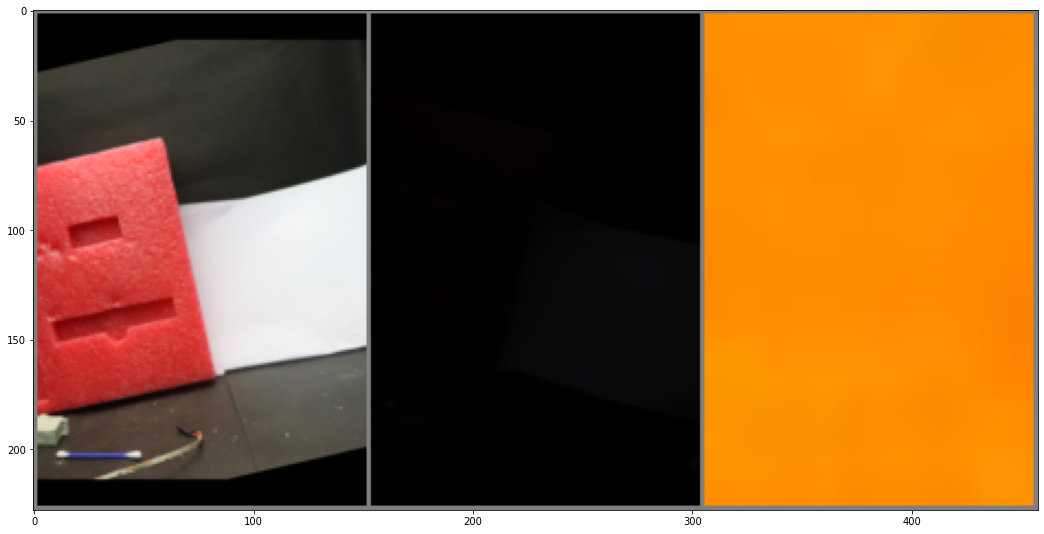

In [29]:
data = iter(pytorch_dataloader1)
images1 = data.next()
print('final shape of data', np.array(images1).shape)
images1=show_img(torchvision.utils.make_grid(images1[0]))

In [ ]:
f.close()

[reference](https://debuggercafe.com/image-augmentation-using-pytorch-and-albumentations/)